<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 4
<br>
<b>Deadline:</b> April 13, 2020 (Monday). 23:00
</div>

# Exercise 6. Neural machine translation with transformers.

The goal of this exerscise is to get familiar with a transformer model, which was introduced in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf).

We base our code on the implementation in the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) blog post. We recommend you to go through that blog post before doing this exercise.

Note: We provide module `transformer.py` which contains some useful modules from the annotated transformer code. We recommend to use those modules when we state so in the description.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import transformer as tr
import tools

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

We use the same translation dataset as in Exercise 5.

In [7]:
# Translation data
from data import TranslationDataset, SOS_token, EOS_token, MAX_LENGTH
trainset = TranslationDataset(data_dir, train=True)

src_seq, tgt_seq = trainset[np.random.choice(len(trainset))]
print('Source sentence:')
print(' as word indexes: ', src_seq)
print(' as words: ', ' '.join(trainset.input_lang.index2word[i.item()] for i in src_seq))

print('Target sentence:')
print(' as word indexes: ', tgt_seq)
print(' as words: ', ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_seq))

Source sentence:
 as word indexes:  tensor([ 24, 246,  25, 247,  96,  35, 681,   5,   1])
 as words:  il n est pas du tout satisfait . EOS
Target sentence:
 as word indexes:  tensor([ 14, 544, 545, 225, 159, 156,   4,   1])
 as words:  he isn t happy at all . EOS


## Custom DataLoader

Next we prepare a custom data loader which puts sequences of varying lengths in one tensor. We do so by using a custom `collate_fn` as explained [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Our collate function combines source sequences in one tensor `src_seqs` with extra values (at the end) filled with `PADDING_VALUE=0`. To tell the transformer which elements are padded, we also need to compute the mask `src_mask`.

The function also combines target sequences in one tensor `tgt_seqs` but it does it a bit differently:
* The resulting tensor is of shape `(max_tgt_seq_length+1, batch_size)`, where `max_tgt_seq_length` is the length of the longest target sequence in the mini-batch.
* The first element of each sequence in the resulting tensor is `SOS_token`.
* The remaining elements are filled similarly to the source sequences with extra values (at the end) filled with `PADDING_VALUE=0`.

We will use tensor `tgt_seqs[:-1]` as inputs of the transformer decoder and `tgt_seqs[1:]` as the targets for the model (decoder) outputs. The `SOS_token` is needed to predict the first word in the output sequence in the corresponding (first) location of the decoder output.

Your task is to implement this function.

In [8]:
from torch.nn.utils.rnn import pad_sequence

PADDING_VALUE = 0

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_seq):
          src_seq is of shape (src_seq_length)
          tgt_seq is of shape (tgt_seq_length)

    Returns:
      src_seqs of shape (max_src_seq_length, batch_size): Tensor of padded source sequences.
      src_mask of shape (max_src_seq_length, batch_size): Boolean tensor showing which elements of the
          src_seqs tensor should be ignored in computations (filled with PADDING_VALUE).
      tgt_seqs of shape (max_tgt_seq_length+1, batch_size): Tensor of padded target sequences.
    """
    len_src,len_tgt=[],[]
    src_seqs, tgt_seqs = [],[]
    for a in list_of_samples:
        len_src.append(len(a[0]))
        src_seqs.append(a[0])
        len_tgt.append(len(a[1]))
        tgt_seqs.append(a[1])
    src_padded, src_mask, tgt_padded = [],[], []
    for seq in src_seqs:
        src_padded.append(list(torch.cat((seq, torch.zeros(max(len_src) - list(seq.shape)[0], dtype=seq.dtype, device=seq.device)), dim=0)))
        src_mask.append(list(torch.cat((torch.zeros(len(seq), dtype=torch.bool,device=device), torch.ones(max(len_src) - list(seq.shape)[0], dtype=torch.bool, device=device)), dim=0)))
    for seq in tgt_seqs:
        tgt_padded.append(list(torch.cat((torch.tensor([SOS_token], dtype=seq.dtype, device=device), seq, torch.zeros(max(len_tgt) - list(seq.shape)[0], dtype=seq.dtype, device=seq.device)), dim=0)))

    src_padded = torch.tensor(np.array(src_padded).T).to(device)
    src_mask = torch.tensor(np.array(src_mask).T).to(device)
    tgt_padded = torch.tensor(np.array(tgt_padded).T).to(device)
    return src_padded, src_mask, tgt_padded


In [9]:
def test_collate_shapes():
    pairs = [
        (torch.LongTensor([2, EOS_token]), torch.LongTensor([3, 4, EOS_token])),
        (torch.LongTensor([6, 7, EOS_token]), torch.LongTensor([9, EOS_token])),
    ]
    src_seqs, src_mask, tgt_seqs = collate(pairs)
    assert src_seqs.dtype == torch.long, f"Wrong src_seqs.dtype: {src_seqs.dtype}"
    assert src_seqs.shape == torch.Size([3, 2]), f"Wrong src_seqs.shape: {src_seqs.shape}"

    assert tgt_seqs.dtype == torch.long, f"Wrong tgt_seqs.dtype: {tgt_seqs.dtype}"
    assert tgt_seqs.shape == torch.Size([4, 2]), f"Wrong tgt_seqs.shape: {tgt_seqs.shape}"
    assert (tgt_seqs[0] == torch.empty(2, dtype=torch.long).fill_(SOS_token)).all(), "Target sequences should start with SOS_token."
    
    assert src_mask.dtype == torch.bool, f"Wrong src_mask.dtype: {src_mask.dtype}"
    assert src_mask.shape == src_seqs.shape, f"Wrong src_mask.shape: {src_mask.shape}"
    print('Success')

test_collate_shapes()

Success


In [10]:
# This cell tests collate()

In [11]:
# We create custom DataLoader using the implemented collate function
# We are going to process 64 sequences at the same time (batch_size=64)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

# Transformer

## Encoder block

<img src="encoder_block.png" width=150 style="float: right;">

We first implement one block of the transformer encoder (see the figure on the right).
* We recommend you to use layers available in PyTorch:
  * [nn.LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) to implement the `Norm` layer in the figure
  * [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) to implement dropout
  * [nn.MultiheadAttention](https://pytorch.org/docs/stable/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention) to implement `Multi-Head Attention`.

* `Feedforward` is simply an MLP processing each position (each element of the source sequence) independently. The exact implementation of the MLP is not tested in this notebook. We used an MLP with:
  * one hidden layer with `n_hidden` neurons
  * a dropout and ReLU activation after the hidden layer
  * an output layer with `n_features` outputs.

* We used dropout in both skip connections of the encoder block.
* In contrast to the [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) code, we applied normalization after the skip connection (like it is shown on the figure).

**We recommend you to test that the padded values of the input sequence do not affect the outputs.**

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          n_features: Number of input and output features.
          n_heads: Number of attention heads in the Multi-Head Attention.
          n_hidden: Number of hidden units in the Feedforward (MLP) block.
          dropout: Dropout rate after the first layer of the MLP and the two skip connections.
        """
        super(EncoderBlock, self).__init__()
        self.multiheadAttention1 = nn.MultiheadAttention(n_features, n_heads)
        self.normlayer1 = nn.LayerNorm(n_features)
        self.normlayer2 = nn.LayerNorm(n_features)
        self.mlp1 = nn.Sequential(nn.Linear(n_features, n_hidden), nn.Dropout(dropout),
                                    nn.ReLU(), torch.nn.Linear(n_hidden,n_features))
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        """
        Args:
          x of shape (max_seq_length, batch_size, n_features): Input sequences.
          mask of shape (batch_size, max_seq_length): Boolean tensor indicating which elements of the input
              sequences should be ignored.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Encoded input sequence.

        Note: All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
        """
        y, _ = self.multiheadAttention1(query=x, key=x, value=x, key_padding_mask=mask)
        x = self.normlayer1(self.drop1(y) + x)
        x = self.normlayer2(x + self.drop2(self.mlp1(x)))
        return x

In [13]:
def test_EncoderBlock_shapes():
    encoder_block = EncoderBlock(n_features=16, n_heads=4, n_hidden=64)

    x = torch.tensor([
        [1, 2],
        [3, 4],
        [5, 0],
        [6, 0],
    ]).float().view(4, 2, 1).repeat(1, 1, 16)  # (max_seq_length, batch_size, n_features)

    mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool).T  # (batch_size, max_seq_length)
    outputs = encoder_block(x, mask)
    assert outputs.shape == torch.Size([4, 2, 16]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_EncoderBlock_shapes()

Success


In [14]:
# This cell tests EncoderBlock

<img src="encoder.png" width=200 style="float: right;">

## Encoder

The encoder is a stack of the following blocks:
* Embedding of words (please use [nn.Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding))
* Positional encoding (please use `tr.PositionalEncoding` from the attached module)
* `n_blocks` of the `EncoderBlock` modules.

Notes:
* Provided implementation of `tr.PositionalEncoding` is the same as in [Annotated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) blog post. See the blog post for more detail.
* Our longest sequences have length `MAX_LENGTH`, this is the value that you can use when you specify `PositionalEncoding`.

In [15]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, n_blocks, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          src_vocab_size: Number of words in the source vocabulary.
          n_blocks: Number of EncoderBlock blocks.
          n_features: Number of features to be used for word embedding and further in all layers of the encoder.
          n_heads: Number of attention heads inside the EncoderBlock.
          n_hidden: Number of hidden units in the Feedforward block of EncoderBlock.
          dropout: Dropout level used in EncoderBlock.
        """
        super(Encoder, self).__init__()
        self.embed1 = nn.Embedding(src_vocab_size, n_features)
        self.pos_embed = tr.PositionalEncoding(n_features, max_len=MAX_LENGTH)
        self.encoder_blks = nn.Sequential(*[EncoderBlock(n_features, n_heads, n_hidden, dropout) for _ in range(n_blocks)])
        
    def forward(self, x, mask):
        """
        Args:
          x of shape (max_seq_length, batch_size): LongTensor with the input sequences.
          mask of shape (batch_size, max_seq_length): BoolTensor indicating which elements should be ignored.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Encoded input sequence.

        Note: All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
        """
        emb = self.embed1(x)
        pos = self.pos_embed(emb)
        inp = emb + pos 
        for layer in self.encoder_blks:
            inp = layer(inp,mask)
        return inp
        

In [16]:
def test_Encoder_shapes():
    encoder = Encoder(src_vocab_size=10, n_blocks=1, n_features=16, n_heads=4, n_hidden=64)

    x = torch.tensor([
        [1, 2],
        [3, 4],
        [5, 0],
        [6, 0],
    ]).view(4, 2)  # (max_seq_length, batch_size)

    mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool).T  # (batch_size, max_seq_length)
    outputs = encoder(x, mask)
    assert outputs.shape == torch.Size([4, 2, 16]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_Encoder_shapes()

Success


# Decoding

## Subsequent mask

In the training loop, we will use target sequences (starting with `SOS_token`) as inputs of the decoder. By doing that, we make it possible for the decoder to use previously decoded words when predicting probabilities of the next word. This idea is similar to the way decoding was done in Exercise 5. However, the computations are parallelized in the transformer decoder, and the probabilities of each word in the target sequence are produced by doing one pass through the decoder.

During decoding, we need to make sure that when we compute the probability of the next word, we only use preceding and not subsequent words. In transformers, this is done by providing a mask which tells which elements should be used or ignored when producing the output. The following function produces this kind of mask.

The $i$-th row in the produced mask says which of the input elements should be used to compute the $i$-th element of the output:
* `0`: the corresponding element of the input sequence can be used.
* `-inf`: the corresponding element of the input sequence cannot be used.

In [17]:
def subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


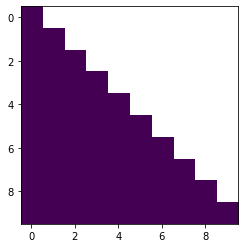

In [18]:
# This is a typical mask that we need to use while decoding
mask = subsequent_mask(10)
print(mask)
plt.imshow(mask)

<img src="decoder_block.png" width=150 style="float: right;">

## Decoder block

Next we implement one block of the transformer decoder (see the figure on the right).
* We recommend you to use layers available in PyTorch:
  * [nn.LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) to implement the `Norm` layer in the figure
  * [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) to implement dropout
  * [nn.MultiheadAttention](https://pytorch.org/docs/stable/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention) to implement `Multi-Head Attention`.

* `Feedforward` is simply an MLP processing each position (each element of the source sequence) independently. The exact implementation of the MLP is not tested in this notebook. We used an MLP with:
  * one hidden layer with `n_hidden` neurons
  * a dropout and ReLU activation after the hidden layer
  * an output layer with `n_features` outputs.

* We used dropout in both skip connections, similarly to the Annotated transformer.

Notes:
* The first attention block is self-attention when query, key and value inputs are same. The second attention block uses the encoded `z` values as keys and values, and the outputs of the previous layer as query.
* **We recommend you to test that the subsequent values of the input sequence do not affect the outputs.**

In [19]:
class DecoderBlock(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          n_features: Number of input and output features.
          n_heads: Number of attention heads in the Multi-Head Attention.
          n_hidden: Number of hidden units in the Feedforward (MLP) block.
          dropout: Dropout rate after the first layer of the MLP and the two skip connections.
        """
        super(DecoderBlock, self).__init__()
        self.multiheadAttention1 = nn.MultiheadAttention(n_features, n_heads)
        self.multiheadAttention2 = nn.MultiheadAttention(n_features, n_heads)
        self.normlayer1 = nn.LayerNorm(n_features)
        self.normlayer2 = nn.LayerNorm(n_features)
        self.normlayer3 = nn.LayerNorm(n_features)
        self.mlp1 = nn.Sequential(nn.Linear(n_features, n_hidden), nn.Dropout(dropout),
                                    nn.ReLU(), torch.nn.Linear(n_hidden,n_features))
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

    def forward(self, y, z, src_mask, tgt_mask):
        """
        Args:
          y of shape (max_tgt_seq_length, batch_size, n_features): Transformed target sequences used as the inputs
              of the block.
          z of shape (max_src_seq_length, batch_size, n_features): Encoded source sequences (outputs of the
              encoder).
          src_mask of shape (batch_size, max_src_seq_length): Boolean tensor indicating which elements of the
             source sequences should be ignored.
          tgt_mask of shape (max_tgt_seq_length, max_tgt_seq_length): Subsequent mask to ignore subsequent
             elements of the target sequences in the inputs. The rows of this matrix correspond to the output
             elements and the columns correspond to the input elements.
        
        Returns:
          z of shape (max_seq_length, batch_size, n_features): Output tensor.

        Note: All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
        """
        x, _ = self.multiheadAttention1(query=y, key=y, value=y, attn_mask =tgt_mask)
        x = self.normlayer1(self.drop1(x) + y)
        y, _ = self.multiheadAttention2(query=x, key=z, value=z, key_padding_mask=src_mask)
        x = self.normlayer2(self.drop2(y) + x)
        x = self.normlayer3(x + self.drop3(self.mlp1(x)))
        return x

In [20]:
def test_DecoderBlock_shapes():
    decoder_block = DecoderBlock(n_features=16, n_heads=4, n_hidden=64)

    y = torch.tensor([
        [1, 2],
        [3, 4],
        [5, 0],
        [6, 0],
    ]).float().view(4, 2, 1).repeat(1, 1, 16)  # (max_seq_length, batch_size, n_features)

    z = torch.randn(4, 2, 16, requires_grad=True)  # (max_seq_length, batch_size, n_features)

    src_mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool).T  # (batch_size, max_seq_length)

    tgt_mask = subsequent_mask(y.size(0))

    outputs = decoder_block(y, z, src_mask=src_mask, tgt_mask=tgt_mask)
    assert outputs.shape == torch.Size([4, 2, 16]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_DecoderBlock_shapes()

Success


In [21]:
# This cell tests DecoderBlock

<img src="decoder.png" width=200 style="float: right;">

## Decoder

The decoder is a stack of the following blocks:
* Embedding of words (please use [nn.Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding))
* Positional encoding (please use `tr.PositionalEncoding` from the attached module)
* `n_blocks` of the `DecoderBlock` modules.
* A linear layer with `tgt_vocab_size` output features.
* Log_softmax nonlinearity.

Note: our longest sequences have length `MAX_LENGTH`, this is the value that you can use when you specify `PositionalEncoding`.

In [22]:
class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, n_blocks, n_features, n_heads, n_hidden=64, dropout=0.1):
        """
        Args:
          tgt_vocab_size: Number of words in the target vocabulary.
          n_blocks: Number of EncoderBlock blocks.
          n_features: Number of features to be used for word embedding and further in all layers of the decoder.
          n_heads: Number of attention heads inside the DecoderBlock.
          n_hidden: Number of hidden units in the Feedforward block of DecoderBlock.
          dropout: Dropout level used in DecoderBlock.
        """
        super(Decoder, self).__init__()
        self.embed1 = nn.Embedding(tgt_vocab_size, n_features)
        self.pos_embed = tr.PositionalEncoding(n_features, max_len=MAX_LENGTH+1)
        self.dencoder_blks = nn.Sequential(*[DecoderBlock(n_features, n_heads, n_hidden, dropout) for _ in range(n_blocks)])
        self.linear_layer = nn.Linear(n_features,tgt_vocab_size)
        
    def forward(self, y, z, src_mask):
        """
        Args:
          y of shape (max_tgt_seq_length, batch_size, n_features): Transformed target sequences used as the inputs
              of the block.
          z of shape (max_src_seq_length, batch_size, n_features): Encoded source sequences (outputs of the
              encoder).
          src_mask of shape (batch_size, max_src_seq_length): Boolean tensor indicating which elements of the
             source sequences should be ignored.
        
        Returns:
          out of shape (max_seq_length, batch_size, tgt_vocab_size): Log-softmax probabilities of the words
              in the output sequences.

        Notes:
          * All intermediate signals should be of shape (max_seq_length, batch_size, n_features).
          * You need to create and use the subsequent mask in the decoder.
        """
        emb = self.embed1(y)
        pos = self.pos_embed(emb)
        inp = emb + pos 
        tgt_masks = subsequent_mask(y.size(0))
        for i,layer in enumerate(self.dencoder_blks):
            #tgt_masks[i,:] = 0
            inp = layer(inp,z,src_mask,tgt_masks)
        x = F.log_softmax(self.linear_layer(inp), dim=2)
        return x

In [23]:
def test_Decoder_shapes():
    decoder = Decoder(tgt_vocab_size=10, n_blocks=1, n_features=16, n_heads=4, n_hidden=64)

    y = torch.tensor([
        [1, 2],
        [3, 4],
        [5, 0],
        [6, 0],
    ])  # (max_seq_length, batch_size, n_features)

    z = torch.randn(4, 2, 16)  # (max_seq_length, batch_size, n_features)

    src_mask = torch.tensor([
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
    ], dtype=torch.bool).T  # (batch_size, max_seq_length)

    outputs = decoder(y, z, src_mask=src_mask)
    assert outputs.shape == torch.Size([4, 2, 10]), f"Wrong outputs.shape: {outputs.shape}"
    print('Success')

test_Decoder_shapes()

Success


# Train the transformer

In [24]:
# Create the transformer model
n_features = 256
encoder = Encoder(src_vocab_size=trainset.input_lang.n_words, n_blocks=3, n_features=n_features,
                  n_heads=16, n_hidden=1024)
decoder = Decoder(tgt_vocab_size=trainset.output_lang.n_words, n_blocks=3, n_features=n_features,
                  n_heads=16, n_hidden=1024)

encoder.to(device)
decoder.to(device)

Decoder(
  (embed1): Embedding(2925, 256)
  (pos_embed): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dencoder_blks): Sequential(
    (0): DecoderBlock(
      (multiheadAttention1): MultiheadAttention(
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (multiheadAttention2): MultiheadAttention(
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (normlayer1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (normlayer2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (normlayer3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp1): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (drop1): Dropout(p=0.1, inplace=False)
      (drop2): Dropout(p=0.1, inplace=False)
      (drop3): Dr

### Training loop

In the training loop, we first encode source sequences using the encoder. Then we decode the encoded sequences by the decoder which also receives shifted target sequences as inputs. The decoder outputs a tensor that contains log-softmax probabilities of words in the output language. You need to use those probabilities to compute the loss. Note that you need to ignore the padded values in the target sequences (similarly to Exercise 5).

The training loss should be smaller than 0.23 at the end of training. 40 epochs is typically enough to get to that level.

**Important: Use the `NoamOptimizer` defined below. If you use standard optimizers like Adam, the optimization procedure will most likely fail.**

In [25]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
adam = torch.optim.Adam(parameters, lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer = tr.NoamOptimizer(n_features, 2, 10000, adam)

In [26]:
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

In [27]:
# Implement the training loop in this cell
if not skip_training:
    %matplotlib inline
    import time
    import pylab as pl
    from IPython import display
    
    def live_plot(data):
        pl.plot(data)
        display.clear_output(wait=True)
        display.display(pl.gcf())
    loss_values = []
    batch_size=64
    criteria = nn.NLLLoss(ignore_index=PADDING_VALUE)
    for i in range(40):
        for j,(sentence_batches, seq_masks, targets)  in enumerate(trainloader):
            optimizer.zero_grad()
            x = encoder.forward(sentence_batches, seq_masks.T)
            dec_out = decoder.forward(targets[:-1], x, seq_masks.T)
            loss = criteria(dec_out.permute((1,2,0)), torch.transpose(targets[1:],0,1))
            loss.backward()
            optimizer.step()
        loss_values.append(loss.item())
        live_plot(loss_values)
        print('Epoch: %d. Training loss: %f' % (i+1, loss.item()))  

In [28]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(encoder, '6_tr_encoder.pth')
    tools.save_model(decoder, '6_tr_decoder.pth')
else:
    encoder = Encoder(src_vocab_size=trainset.input_lang.n_words, n_blocks=3, n_features=256, n_heads=16, n_hidden=1024)
    tools.load_model(encoder, '6_tr_encoder.pth', device)
    
    decoder = Decoder(tgt_vocab_size=trainset.output_lang.n_words, n_blocks=3, n_features=256, n_heads=16, n_hidden=1024)
    tools.load_model(decoder, '6_tr_decoder.pth', device)

Model loaded from 6_tr_encoder.pth.
Model loaded from 6_tr_decoder.pth.


In [29]:
# This cell tests the trained transformer

# Generate translations with the trained model

In the cell below, implement a function that converts an input sequence to an output sequence using the trained transformer.

In [30]:
def translate(encoder, decoder, src_seq):
    """
    Args:
      encoder (Encoder): Trained encoder.
      decoder (Decoder): Trained decoder.
      src_seq of shape (src_seq_length): LongTensor of word indices of the source sentence.
    
    Returns:
      out_seq of shape (out_seq_length, 1): LongTensor of word indices of the output sentence.
    """
    seq_mask = torch.zeros_like(src_seq, dtype=torch.bool)
    x = encoder.forward(src_seq.unsqueeze(0), seq_mask.unsqueeze(1))
    tgt_sub = [SOS_token,]
    i=0
    while True:
        dec_out = decoder.forward(torch.tensor(tgt_sub, device=device).unsqueeze(1), x, seq_mask.unsqueeze(1).T)
        dec_out = torch.argmax(dec_out, dim=2)
        tgt_sub.append(dec_out[i])
        if dec_out[i] == EOS_token :
            break
        i+=1
    return dec_out

Below, we translate sentences from the training set. For a well-trained transformer, the translations should look similar to the target sentences.

In [31]:
print('Translate training data:')
print('-----------------------------')
for i in range(5):
    src_sentence, tgt_sentence = trainset[np.random.choice(len(trainset))]
    print('>', ' '.join(trainset.input_lang.index2word[i.item()] for i in src_sentence))
    print('=', ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_sentence))
    out_sentence = translate(encoder, decoder, src_sentence)
    print('<', ' '.join(trainset.output_lang.index2word[i.item()] for i in out_sentence), '\n')

Translate training data:
-----------------------------
> je suis moi meme un peu lecteur . EOS
= i m a bit of a reader myself . EOS
< i m a bit of a reader myself . EOS 

> je suis en train d apprendre le francais . EOS
= i m learning french . EOS
< i m managing it . EOS 

> nous sommes tous en securite . EOS
= we re all safe . EOS
< we re all done . EOS 

> elle est en colere contre moi . EOS
= she is mad at me . EOS
< she is mad at me . EOS 

> je suis tout seul . EOS
= i m all alone . EOS
< i m very hungry . EOS 



Below, we translate sentences from the test set. For a well-trained transformer, the translations are typically
worse than for the training sequences but they still look reasonable.

In [32]:
testset = TranslationDataset(data_dir, train=False)

In [33]:
print('Translate test data:')
print('-----------------------------')
for i in range(5):
    input_sentence, target_sentence = testset[np.random.choice(len(testset))]
    print('>', ' '.join(testset.input_lang.index2word[i.item()] for i in input_sentence))
    print('=', ' '.join(testset.output_lang.index2word[i.item()] for i in target_sentence))
    output_sentence = translate(encoder, decoder, input_sentence)
    print('<', ' '.join(testset.output_lang.index2word[i.item()] for i in output_sentence), '\n')

Translate test data:
-----------------------------
> je ne vais pas attendre . EOS
= i m not going to wait . EOS
< i m not waiting for it . EOS 

> vous etes tellement idiote ! EOS
= you are so stupid . EOS
< you re so predictable . EOS 

> c est toi qui t es emballe . EOS
= you re the one that went crazy . EOS
< you re kind of mine . EOS 

> vous etes tres occupes . EOS
= you re very busy . EOS
< you re very busy . EOS 

> je vais rentrer a la maison demain . EOS
= i m going back home tomorrow . EOS
< i m going to the house . EOS 

